<a href="https://colab.research.google.com/github/ShinAsakawa/2019komazawa/blob/master/notebooks/2019komazawa_pca_tsne_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 駒沢大学 心理学特殊演習IIIA

Date: 2019年05月31日

## PCA and t-SNE 実習



In [1]:
# 必要なライブラリの輸入
import numpy as np
import math

print('gamma(1/2): {}'.format(math.gamma(1/2)))  # $\Gamma(1/2) の値の表示
print('gamma(1): {}'.format(math.gamma(1)))      # $\Gamma(1) の値の表示

for i in range(1,11):  # 1 から 10 までの繰り返し
    print(i, math.gamma(i))  # それぞれの値を表示

math.sqrt(math.pi) == math.gamma(1/2)

gamma(1/2): 1.7724538509055159
gamma(1): 1.0
1 1.0
2 1.0
3 2.0
4 6.0
5 24.0
6 120.0
7 720.0
8 5040.0
9 40320.0
10 362880.0


True

注: 上のセルで最終行は $\Gamma\left(\pi\right)$ と $\displaystyle\Gamma\left(\frac{1}{2}\right)$ とを比較しています

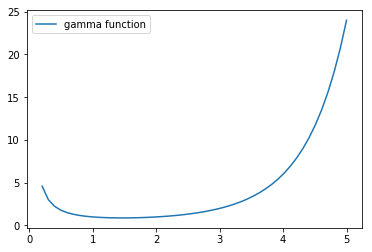

In [2]:
# ガンマ関数曲線を描画する
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(0.2, 5.0)  # x 定義域は 0.2 <= x < 5.0
y = [math.gamma(xi) for xi in x]
plt.plot(x,y, label='gamma function')
plt.legend()
plt.show()

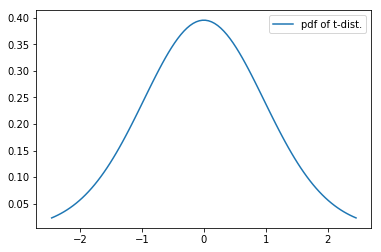

In [3]:
# t 分布の確率密度曲線を描画する
from scipy.stats import t

nu = 30
x = np.linspace(t.ppf(0.01, nu), t.ppf(0.99, nu), 100)
y = [t.pdf(xi,nu) for xi in x]
plt.plot(x,y, label='pdf of t-dist.')
plt.legend()
plt.show()

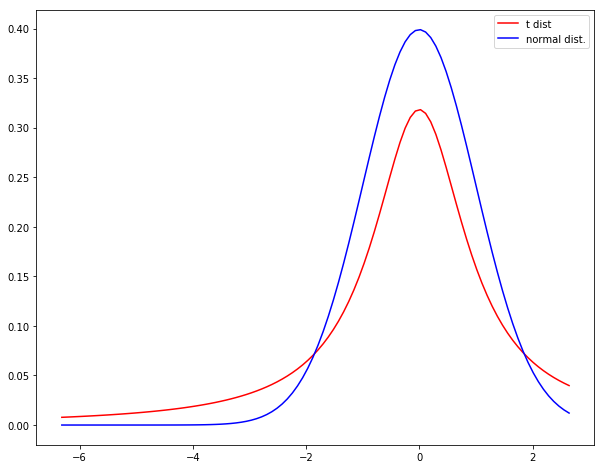

In [4]:
# 正規分布と比較してみる
from scipy.stats import norm

plt.rcParams['figure.figsize'] = [10, 8]
nu = 1
x = np.linspace(t.ppf(0.05, nu), norm.ppf(0.95, nu), 100)
plt.plot(x, t.pdf(x, nu), 'r-', label='t dist')
plt.plot(x, norm.pdf(x), 'b-', label='normal dist.')
plt.legend()
#plt.savefig('t-and-norm-dists.pdf')
plt.show()

---

# つづいて fashion mnist による PCA と t-SNE のプロット

- Original: <https://github.com/zalandoresearch/fashion-mnist>

<center>
<img src='https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png'
     style='width:74%'><br>
</center>

---

<center>
<img src='https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/embedding.gif' style='width:64%'><br>
</center>

---

| Label | Description |
|------ | ----------- |
| 0     | T-shirt/top |
|1      | Trouser     |
|2      | Pullover    |
|3      | Dress       |
|4	    | Coat        |
|5      | Sandal      |
|6      | Shirt       |
|7      | Sneaker     |
|8      | Bag         |
|9      | Ankle boot  |


In [0]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [0]:
# データの取得
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2019-05-30 14:32:26--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.106
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.74.106|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  11.7MB/s    in 2.2s    

2019-05-30 14:32:29 (11.7 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2019-05-30 14:32:30--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.54
Connecting to fashion-mnist.s3-website.eu-central-1.amazo

In [0]:
!ls *-ubyte.gz

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [0]:
X_train, y_train = load_mnist('./', kind='train')

In [0]:
X_train.shape
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [0]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

In [0]:
# Utility function to visualize the outputs of PCA and t-SNE
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):
        # Position of each label at median of data points.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [0]:
# Subset first 20k data points to visualize
x_subset = X_train[0:20000]
y_subset = y_train[0:20000]

print(np.unique(y_subset))

[0 1 2 3 4 5 6 7 8 9]


In [0]:
from sklearn.decomposition import PCA

time_start = time.time()

pca = PCA(n_components=4)
pca_result = pca.fit_transform(x_subset)

print('PCA done! Time elapsed: {0} seconds'.format(time.time()-time_start))

PCA done! Time elapsed: 1.638108491897583 seconds


In [0]:
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

Variance explained per principal component: [0.29021329 0.1778743  0.06015076 0.04975864]


(<Figure size 576x576 with 1 Axes>,
 [Text(774.4497664222484, -689.6949155580309, '0'),
  Text(42.86381925975385, -1429.3643908425095, '1'),
  Text(1098.2843326496131, 376.9753232996362, '2'),
  Text(329.2719860679182, -1111.4898090757547, '3'),
  Text(1266.9709868261484, 295.46620083374495, '4'),
  Text(-1589.55732339194, 61.86773393747342, '5'),
  Text(713.4727983677299, -65.68701122614348, '6'),
  Text(-1521.4109429505893, 335.665625316945, '7'),
  Text(63.81768171698837, 1003.3250404612146, '8'),
  Text(-645.6906091267462, 1168.2384038928592, '9')])

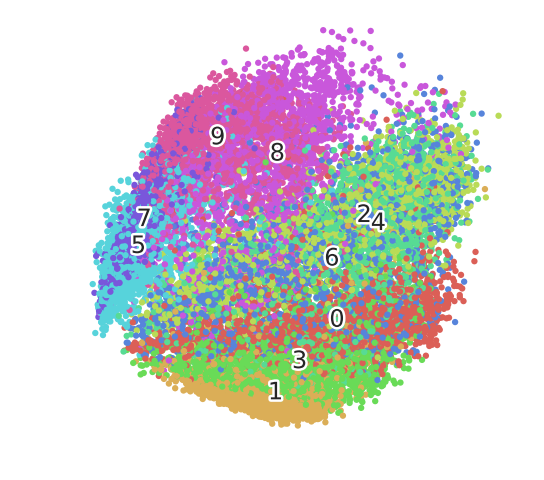

In [0]:
top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component

fashion_scatter(top_two_comp.values,y_subset) # Visualizing the PCA output

In [0]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

fashion_tsne = TSNE(random_state=RS).fit_transform(x_subset)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

(<Figure size 576x576 with 1 Axes>,
 [Text(41.57853, 6.2938895, '0'),
  Text(16.529232, 61.37285, '1'),
  Text(13.9984, -39.075554, '2'),
  Text(23.668945, 24.115776, '3'),
  Text(31.92881, -32.853615, '4'),
  Text(-36.646145, 5.3290944, '5'),
  Text(16.96063, -17.384825, '6'),
  Text(-59.432877, -11.076068, '7'),
  Text(-22.520933, -37.156204, '8'),
  Text(-34.86377, 39.52498, '9')])

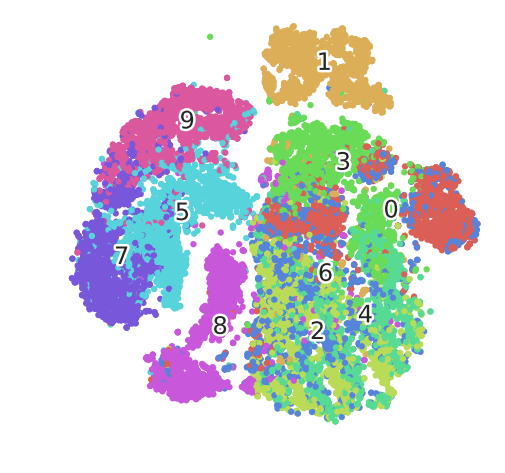

In [0]:
fashion_scatter(fashion_tsne, y_subset)

In [0]:
time_start = time.time()

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(x_subset)

print('PCA with 50 components done! Time elapsed: {} seconds'.format(time.time()-time_start))
print('Cumulative variance explained by 50 principal components: {}'.format(
    np.sum(pca_50.explained_variance_ratio_)))

PCA with 50 components done! Time elapsed: 1.5678892135620117 seconds
Cumulative variance explained by 50 principal components: 0.8625128004488235


In [0]:
import time
time_start = time.time()

fashion_pca_tsne = TSNE(random_state=RS).fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 216.8337688446045 seconds


(<Figure size 576x576 with 1 Axes>,
 [Text(40.496334, 5.7726674, '0'),
  Text(7.997444, 62.93495, '1'),
  Text(16.261547, -40.764008, '2'),
  Text(28.849264, 31.1598, '3'),
  Text(34.135254, -35.011967, '4'),
  Text(-35.10913, 3.0841556, '5'),
  Text(21.227905, -19.367043, '6'),
  Text(-60.25031, -16.684946, '7'),
  Text(-19.808342, -32.368877, '8'),
  Text(-43.507698, 39.247673, '9')])

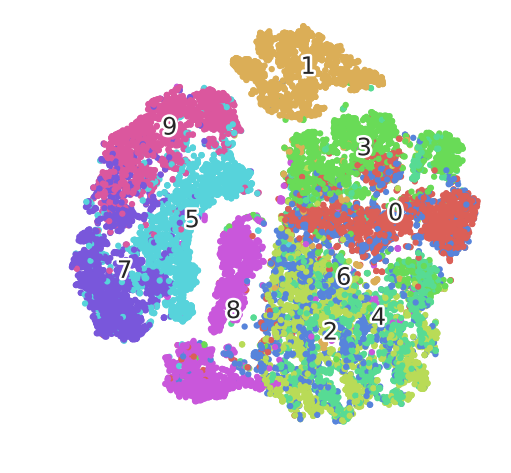

In [0]:
fashion_scatter(fashion_pca_tsne, y_subset)